# Applied Deep Learning: Forecasting Cryptocurrencies

As part of my continued journey into learning Machine Learning and Deep Learning. This project tackles an application of LSTM in a applicable real-world scenario in forecasting Cryptocurrenies. 

Long Short Term Memory (LSTM) is a deep learning model which is very well suited to time series data or any data with temporal/spatial/structural order. I will be briefly explaning how LSTM works, if you wish spend more time further understanding/researching the underlying theory, I'd have linked the resources I have used while I was researching this myself. 
link
link
link

LSTM are a special kind of Recurrent Neural Network, capable of learning long term dependecies. They are able to do this by:

- Ddding a forgetting mechanism
- Adding a saving mechanism
- Focusing long-term memory into working memory

so when a new input comes in , the model first forgets any long term information it decided it no longer needs, and then learns parts of the new input which it deems worth using and saves it into its long-term memory. Wheresas RNN can overwrite its memory at each step in a fairly uncontrolled fashion, LSTM transforms its memory in a very precise manner, by using specific learning mechanisms for which pieces of information to remember, which to update, and which to pay attention to. This all helps its keep track of information over longer periods of time. 

# Data

The data is obtained off CoinMarketCap's API. By doing this, we will definelty have sufficient amounts of data. Furthermore, the CoinMarketCap's API provides day to day prices of Cryptocurrencies which is a good timescale for the data. 

Since we will we combining multiple cryptos in one model, its best to pull the data from one source. For now, we will only consider Bitcoin and Etherum as they are they are the most popular coins at the moment, however it wouldn't be hard to add the latest hyped altcoin using this approach.

Before we import the data, we first load the required python packages for this notebook.

In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
sns.set()

In [2]:
#get market info for bitcoin from the start of 2013 to the current day 
bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]

#convert the date straing to correct date format
bitcoin_market_info = bitcoin_market_info.assign(Date = pd.to_datetime(bitcoin_market_info["Date"]))

#when volume is equal "-" convert it to 0
bitcoin_market_info["Volume"].replace("-", 0)

#remove astericks
bitcoin_market_info.columns = bitcoin_market_info.columns.str.replace("*", "")
bitcoin_market_info.head()

#do the same for etherum

# get market info for ethereum from the start of 2016 to the current day
eth_market_info = pd.read_html("https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
eth_market_info = eth_market_info.assign(Date=pd.to_datetime(eth_market_info['Date']))
# coinmarketcap starting returning asterisks in the column names, this will remove those asterisks
eth_market_info.columns = eth_market_info.columns.str.replace("*", "")
# look at the first few rows
eth_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2019-07-01,290.27,301.03,280.02,293.64,10292223948,31338571563
1,2019-06-30,319.58,322.79,290.70,290.70,10303111000,31020295932
2,2019-06-29,311.28,322.04,294.75,320.06,10929374565,34149263832
3,2019-06-28,294.14,313.03,292.94,311.23,11514656820,33202586960
4,2019-06-27,336.96,343.43,278.57,294.27,14038092503,31389390615


We have now loaded the required packages and imported the data from coinmarketcap.

We do a litte bit of data cleaning, to arrive at the table above. We can prove that the data is accurate, we plot the price of both cryptos over time. 

In [3]:
# scraping imgs of BTC and ETH

import sys
from PIL import Image
import io

if sys.version_info[0] < 3:
    import urllib2 as urllib
    btc_img = urllib.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")
    eth_img = urllib.urlopen("https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Ethereum_logo_2014.svg/256px-Ethereum_logo_2014.svg.png")
else:
    import urllib
    btc_img = urllib.request.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")
    eth_img = urllib.request.urlopen("https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Ethereum_logo_2014.svg/256px-Ethereum_logo_2014.svg.png")

image_file = io.BytesIO(btc_img.read())
bitcoin_im = Image.open(image_file)

image_file = io.BytesIO(eth_img.read())
eth_im = Image.open(image_file)
width_eth_im , height_eth_im  = eth_im.size
eth_im = eth_im.resize((int(eth_im.size[0]*0.8), int(eth_im.size[1]*0.8)), Image.ANTIALIAS)


# changing column names

bitcoin_market_info.columns = [bitcoin_market_info.columns[0]] + ["btc_" + i for i in bitcoin_market_info.columns[1:]]
eth_market_info.columns = [eth_market_info.columns[0]] + ["eth_" + i for i in eth_market_info.columns[1:]]

C:\Users\Jackson\Anaconda2\envs\tensorflow\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


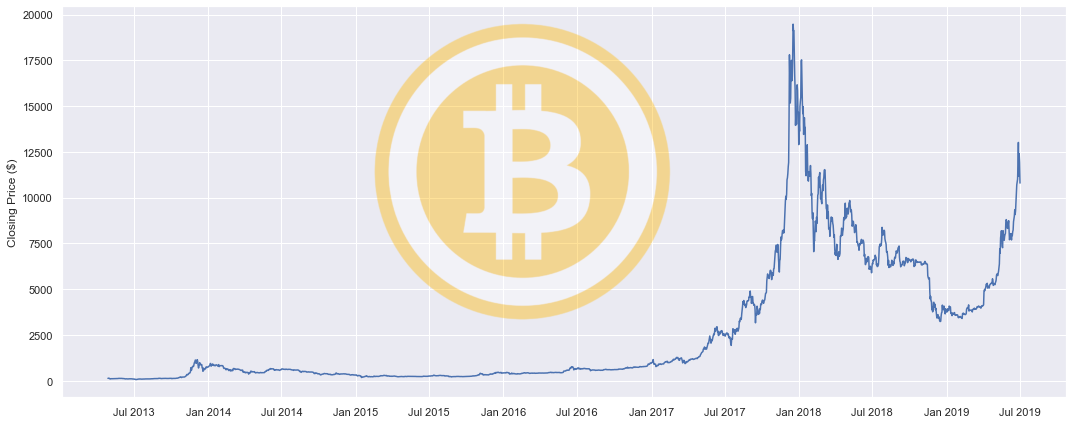

In [4]:
fig, (ax1) = plt.subplots(1,1, figsize=(15,6))
ax1.set_ylabel('Closing Price ($)',fontsize=12)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2020) for j in [1,7]])
ax1.set_xticklabels('')
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2020) for j in [1,7]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2020) for j in [1,7]])
ax1.plot(bitcoin_market_info['Date'].astype('datetime64[ns]'),bitcoin_market_info['btc_Open'])
fig.tight_layout()
fig.figimage(bitcoin_im, 200, 10, zorder=3,alpha=.4)
plt.show()

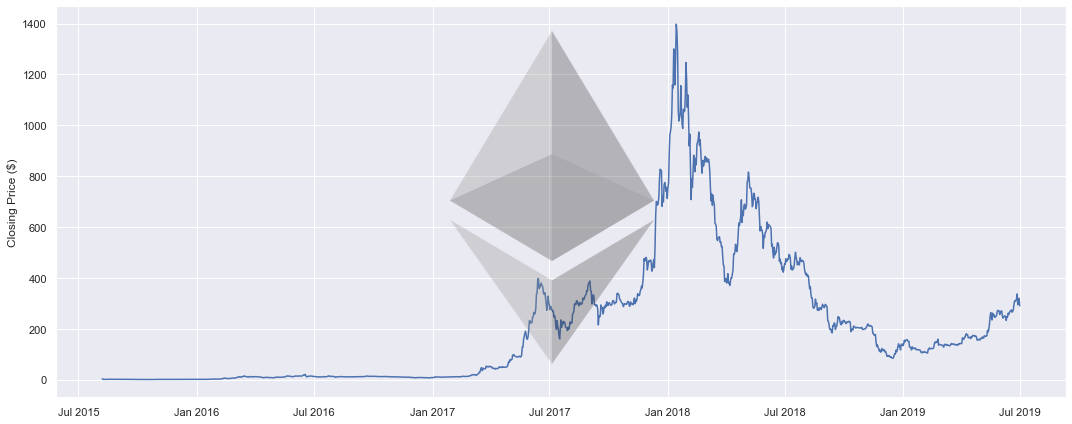

In [5]:
fig, (ax1) = plt.subplots(1,1, figsize=(15,6))
ax1.set_ylabel('Closing Price ($)',fontsize=12)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2020) for j in [1,7]])
ax1.set_xticklabels('')
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2020) for j in [1,7]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2020) for j in [1,7]])
ax1.plot(eth_market_info['Date'].astype('datetime64[ns]'),eth_market_info['eth_Open'])
fig.tight_layout()
fig.figimage(eth_im, 450, 60, zorder=3,alpha=.3)
plt.show()

In [6]:
market_info = pd.merge(bitcoin_market_info, eth_market_info, on=["Date"])
market_info = market_info[market_info["Date"] >= "2013-01-01"]

for coins in ['btc_', 'eth_']: 
    kwargs = { coins+'day_diff': lambda x: (x[coins+'Close']-x[coins+'Open'])/x[coins+'Open']}
    market_info = market_info.assign(**kwargs)
market_info.head()

,Date,btc_Open,btc_High,btc_Low,btc_Close,btc_Volume,btc_Market Cap,eth_Open,eth_High,eth_Low,eth_Close,eth_Volume,eth_Market Cap,btc_day_diff,eth_day_diff
0,2019-07-01,10796.93,11206.44,10089.31,10583.13,29378589324,188297637574,290.27,301.03,280.02,293.64,10292223948,31338571563,-0.019802,0.011610
1,2019-06-30,11931.99,12178.38,10799.01,10817.16,27256473494,192442065810,319.58,322.79,290.70,290.70,10303111000,31020295932,-0.093432,-0.090369
2,2019-06-29,12400.76,12400.91,11508.38,11959.37,29923961128,212739713110,311.28,322.04,294.75,320.06,10929374565,34149263832,-0.035594,0.028206
3,2019-06-28,11162.17,12445.18,10914.49,12407.33,35087757766,220681459666,294.14,313.03,292.94,311.23,11514656820,33202586960,0.111552,0.058102
4,2019-06-27,13017.12,13311.14,10491.85,11182.81,39977475223,198878940964,336.96,343.43,278.57,294.27,14038092503,31389390615,-0.140915,-0.126692


# Training, Test & Random Walks

Now that we have some data, so now we need to build a model. In deep learning, the data is typically split into training and test sets. The model is built on the training set and subsquently evaluated on the unseen test set. In time series models, we generally train on one period of time and then test on the another separate period. Rather arbitrarily, I'll set the cut-off date to June 2019 (i.e model will be trained on data before that date and assessed on data after it).

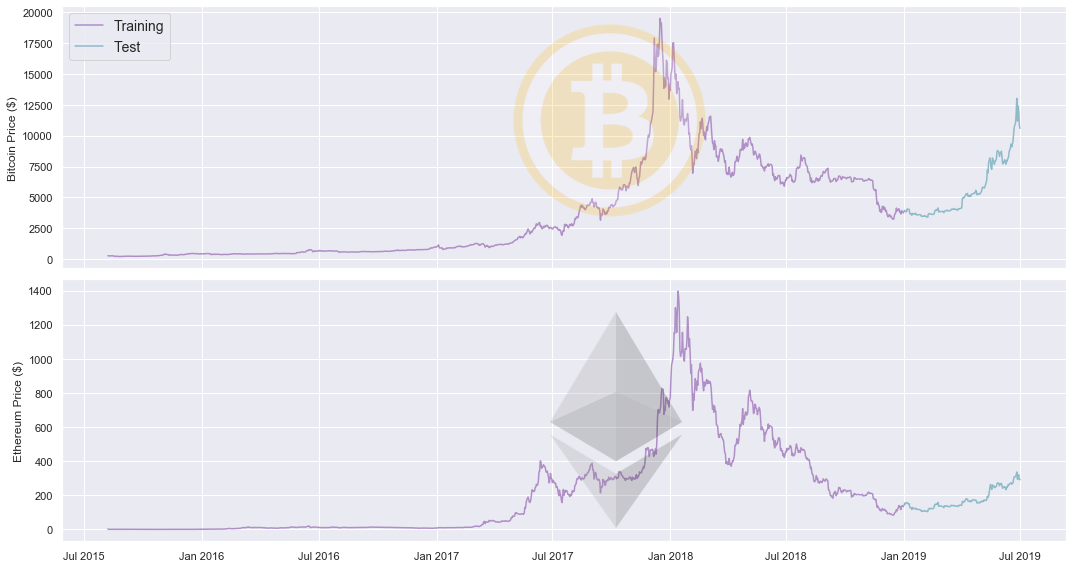

In [7]:
split_date = '2019-01-01'
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,8))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2020) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2020) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2020) for j in [1,7]])

ax1.plot(market_info[market_info['Date'] < split_date]['Date'],
         market_info[market_info['Date'] < split_date]['btc_Close'], 
         color='#B08FC7', label='Training')
ax1.plot(market_info[market_info['Date'] >= split_date]['Date'],
         market_info[market_info['Date'] >= split_date]['btc_Close'],
         color='#8FBAC8', label='Test')
ax2.plot(market_info[market_info['Date'] < split_date]['Date'],
         market_info[market_info['Date'] < split_date]['eth_Close'], 
         color='#B08FC7')
ax2.plot(market_info[market_info['Date'] >= split_date]['Date'],
         market_info[market_info['Date'] >= split_date]['eth_Close'], color='#8FBAC8')

ax1.set_xticklabels('')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
plt.tight_layout()
ax1.legend(loc='upper left',prop={'size': 14})

fig.figimage(bitcoin_im.resize((int(bitcoin_im.size[0]*0.65), int(bitcoin_im.size[1]*0.65)), Image.ANTIALIAS), 
             400, 290, zorder=3,alpha=.2)
fig.figimage(eth_im.resize((int(eth_im.size[0]*0.65), int(eth_im.size[1]*0.65)), Image.ANTIALIAS), 
             550, 40, zorder=3,alpha=.2)
plt.show()

You can see that the traning period mostly consists of the periods when cyptos were relatively cheaper. As such, the training data may not be representative of test data, undermining the model's ability to generalise to unseen data ( you could try to make your data staionary - dicussed here). 
But why let negative realisties get in the way of baseless optimism? Before we implement our deep learning model, its worth discussing a simpler model. The most basic model is to set tomorrow's price equal to today's price ( which we will call a lag model). This is how we'd define such a model in mathematical terms:

$$Pred Price_{t} = Actual Price_{t-1}$$

### Lag Model

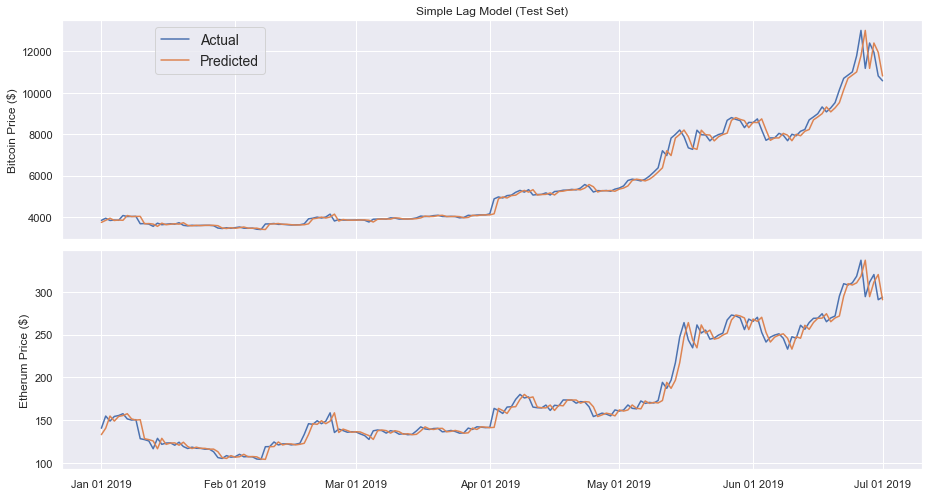

In [8]:
# First we test out a very simple model - Lag Model
# trivial lag model: P_t = P_(t-1)
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(13,7))

ax1.set_xticks([datetime.date(2019, i+1,1) for i in range(12)])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(2019, i+1,1) for i in range(12)])
ax2.set_xticklabels([datetime.date(2019,i+1,1).strftime('%b %d %Y')  for i in range(12)])


ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype('datetime64[ns]'),
         market_info[market_info['Date']>= split_date]['btc_Close'].values, label='Actual')
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype('datetime64[ns]'),
          market_info[market_info['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                      datetime.timedelta(days=1)]['btc_Close'][1:].values, label='Predicted')

ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, prop={'size': 14})
ax1.set_title('Simple Lag Model (Test Set)')
ax2.set_ylabel('Etherum Price ($)',fontsize=12)

ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype('datetime64[ns]'),
         market_info[market_info['Date']>= split_date]['eth_Close'].values, label='Actual')

ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype('datetime64[ns]'),
          market_info[market_info['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                      datetime.timedelta(days=1)]['eth_Close'][1:].values, label='Predicted')
fig.tight_layout()
plt.show()

Extending this trivial lag model, stock prices commonly treated as random walks, which can be defined in these mathematical terms:

$$ Pred Price_{t} = Actual Price_{t-1}* \epsilon\ , \epsilon\ ~ N *(\mu, \sigma) $$

We'll determine $\mu$ $\sigma$ from the training sets and apply the random walk model to the Bitcoin and Ethereum test sets.

First, we may want to make sure the daily change in price follows a normal distribution. We'll plot the histogram of values. 

### Random Walk

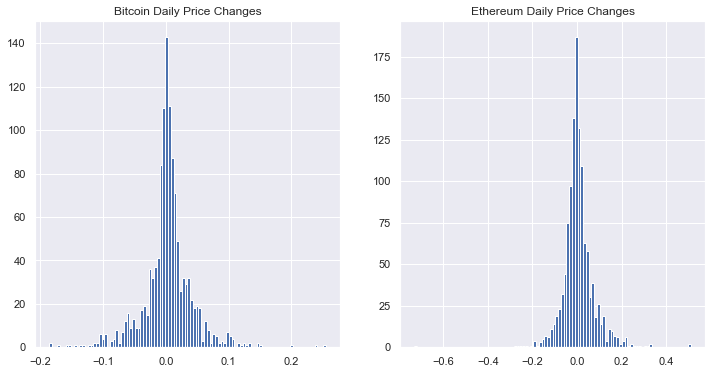

In [9]:
# Try random walk
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6))
ax1.hist(market_info[market_info['Date']< split_date]['btc_day_diff'].values, bins=100)
ax2.hist(market_info[market_info['Date']< split_date]['eth_day_diff'].values, bins=100)
ax1.set_title('Bitcoin Daily Price Changes')
ax2.set_title('Ethereum Daily Price Changes')
plt.show()

In [10]:
np.random.seed(42)

btc_r_walk_mean, btc_r_walk_sd = np.mean(market_info[market_info["Date"] < split_date]["btc_day_diff"].values),\
np.std(market_info[market_info['Date']< split_date]['btc_day_diff'].values)

btc_random_steps = np.random.normal(btc_r_walk_mean, btc_r_walk_sd, 
                (max(market_info['Date']) - datetime.datetime.strptime(split_date, '%Y-%m-%d')).days + 1)

eth_r_walk_mean, eth_r_walk_sd = np.mean(market_info[market_info["Date"] < split_date]["eth_day_diff"].values),\
np.std(market_info[market_info['Date']< split_date]['eth_day_diff'].values)

eth_random_steps = np.random.normal(eth_r_walk_mean, eth_r_walk_sd, 
                (max(market_info['Date']) - datetime.datetime.strptime(split_date, '%Y-%m-%d')).days + 1)

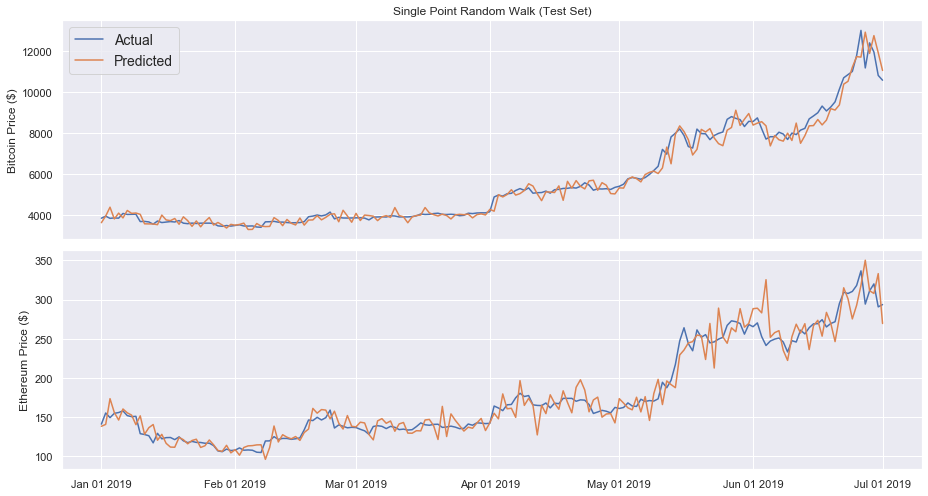

In [11]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(13,7))


ax1.set_xticks([datetime.date(2019,i+1,1) for i in range(12)])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(2019,i+1,1) for i in range(12)])
ax2.set_xticklabels([datetime.date(2019,i+1,1).strftime('%b %d %Y')  for i in range(12)])


ax1.plot(market_info[market_info['Date']>= split_date]['Date'],
     market_info[market_info['Date']>= split_date]['btc_Close'].values, label='Actual')
ax1.plot(market_info[market_info['Date']>= split_date]['Date'],
      market_info[(market_info['Date']+ datetime.timedelta(days=1))>= split_date]['btc_Close'].values[1:] * 
     (1+btc_random_steps), label='Predicted')


ax2.plot(market_info[market_info['Date']>= split_date]['Date'],
     market_info[market_info['Date']>= split_date]['eth_Close'].values, label='Actual')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'],
      market_info[(market_info['Date']+ datetime.timedelta(days=1))>= split_date]['eth_Close'].values[1:] * 
     (1+eth_random_steps), label='Predicted')


ax1.set_title('Single Point Random Walk (Test Set)')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(loc=2, prop={'size': 14})
plt.tight_layout()
plt.show()

From first glance it seems these predictions are amazing! Apart from a few kinks, it broadly tracks the actual closing price for each coin. It captures the rise of ETH and BTC from May to Jun. 

As pointed out by many other blogs, models that only make predictions one point into the future are often misleadingly accurate, as errors aren't carried over to the subsequent predictions. Now matter how large the error is, it is reset at each point in time as the model the fed the true price. The BTC random walk is particularly deceptive as the sccale of the y-axis is quite wide, making the prediction line appear quite smooth, when it is probably not any better than the ETH prediction. 

Single point predicitions are unfortunately quite common when evaluating time series models. A better idea could be to measure its accuracy on multipoint predictions. That way, errors from previous predictions aren't reset but rather are compounded by subsequent predictions. Thus poor models are heavily penalized.

Let's get our random walk model to predict thse closing prices over the total test set. 

In [12]:
btc_random_walk = []
eth_random_walk = []

for n_step, (btc_step, eth_step) in enumerate(zip(btc_random_steps, eth_random_steps)):
    if n_step==0:
        btc_random_walk.append(market_info[market_info['Date']< split_date]['btc_Close'].values[0] * (btc_step+1))
        eth_random_walk.append(market_info[market_info['Date']< split_date]['eth_Close'].values[0] * (eth_step+1))
    else:
        btc_random_walk.append(btc_random_walk[n_step-1] * (btc_step+1))
        eth_random_walk.append(eth_random_walk[n_step-1] * (eth_step+1))

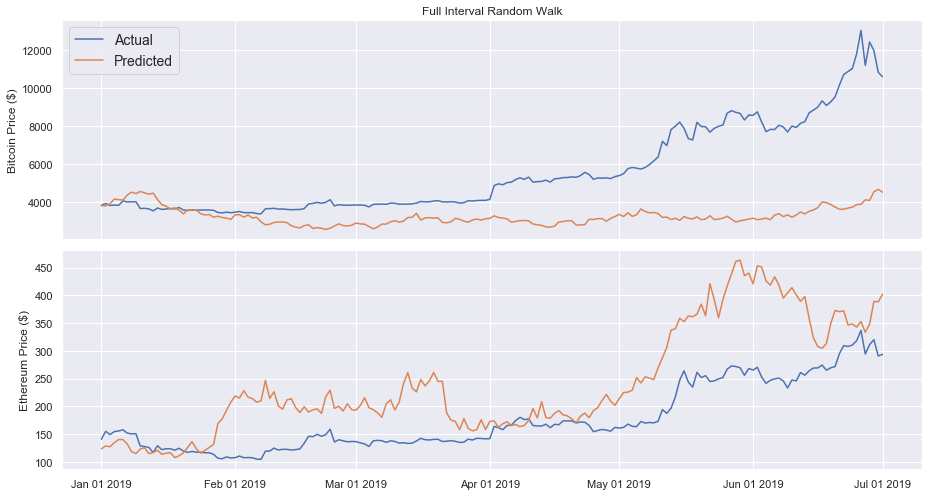

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13,7))
ax1.set_xticks([datetime.date(2019,i+1,1) for i in range(12)])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(2019,i+1,1) for i in range(12)])
ax2.set_xticklabels([datetime.date(2019,i+1,1).strftime('%b %d %Y')  for i in range(12)])

ax1.plot(market_info[market_info['Date']>= split_date]['Date'],
         market_info[market_info['Date']>= split_date]['btc_Close'].values, label='Actual')
ax1.plot(market_info[market_info['Date']>= split_date]['Date'],
         btc_random_walk[::-1], label='Predicted')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'],
         market_info[market_info['Date']>= split_date]['eth_Close'].values, label='Actual')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'],
         eth_random_walk[::-1], label='Predicted')

ax1.set_title('Full Interval Random Walk')
ax1.set_ylabel('Bitcoin Price ($)')
ax2.set_ylabel('Ethereum Price ($)')
ax1.legend(loc=2, prop={'size': 14})

plt.tight_layout()
plt.show()

The model predictions are extremely sensitive to the random seed. I chosen a a range from 0 to 50 to show this effect. You can interactively play around with the seed value below to see badly it can perform.

In [14]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def plot_func(freq):
    
    np.random.seed(freq)
    
    random_steps = np.random.normal(eth_r_walk_mean, eth_r_walk_sd, 
                (max(market_info['Date']).to_pydatetime() - datetime.datetime.strptime(split_date, '%Y-%m-%d')).days + 1)
    random_walk = []
    
    for n_step,i in enumerate(random_steps):
        if n_step==0:
            random_walk.append(market_info[market_info['Date']< split_date]['eth_Close'].values[0] * (i+1))
        else:
            random_walk.append(random_walk[n_step-1] * (i+1))
    
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(13,7))
    
    ax1.set_xticks([datetime.date(2019,i+1,1) for i in range(12)])
    ax1.set_xticklabels('')
    ax2.set_xticks([datetime.date(2019,i+1,1) for i in range(12)])
    ax2.set_xticklabels([datetime.date(2019,i+1,1).strftime('%b %d %Y')  for i in range(12)])
    
    ax1.plot(market_info[market_info['Date']>= split_date]['Date'],
         market_info[market_info['Date']>= split_date]['eth_Close'].values, label='Actual')
    
    ax1.plot(market_info[market_info['Date']>= split_date]['Date'],
          market_info[(market_info['Date']+ datetime.timedelta(days=1))>= split_date]['eth_Close'].values[1:] * 
         (1+random_steps), label='Predicted')
    
    ax2.plot(market_info[market_info['Date']>= split_date]['Date'],
          market_info[(market_info['Date']+ datetime.timedelta(days=1))>= split_date]['eth_Close'].values[1:] * 
         (1+random_steps))
    
    ax2.plot(market_info[market_info['Date']>= split_date]['Date'],
             random_walk[::-1])
    
    ax1.set_title('Single Point Random Walk')
    ax1.set_ylabel('')
    # for static figures, you may wish to insert the random seed value
#    ax1.annotate('Random Seed: %d'%freq, xy=(0.75, 0.2),  xycoords='axes fraction',
#            xytext=(0.75, 0.2), textcoords='axes fraction')
    ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
    ax2.set_title('Full Interval Random Walk')
    
    fig.text(0.0, 0.5, 'Ethereum Price ($)', va='center', rotation='vertical',fontsize=12)
    plt.tight_layout()
#    plt.savefig('image%d.png'%freq, bbox_inches='tight')
    plt.show()
    
interact(plot_func, freq =widgets.IntSlider(min=0,max=50,step=1,value=205, description='Random Seed:'))

interactive(children=(IntSlider(value=50, description='Random Seed:', max=50), Output()), _dom_classes=('widge…

<function __main__.plot_func(freq)>

Notice how the single point random walk always  looks quite accurate, even tough theres no real substance behind it. This will hopefully prove to you that single point random walks can't actually accurately predict prices.

# Long Short Term Memory (LSTM)

If you're interested in the theory behind LSTMs, there are the links from above. Luckily for us, we won't be building the network from scratch, there exist packages that include standard implementations of various deep learning algorithms. I will be using Keras/Tensorflow as I am most comfortable using this package.

In [15]:
for coins in ["btc_", "eth_"]:
    kwargs = { 
        coins+'close_off_high': lambda x: 2*(x[coins+'High']- x[coins+'Close'])/(x[coins+'High']-x[coins+'Low'])-1,
        coins+'volatility': lambda x: (x[coins+'High']- x[coins+'Low'])/(x[coins+'Open'])}
    market_info = market_info.assign(**kwargs)

In [16]:
model_data = market_info[['Date']+[coin+metric for coin in ['btc_', 'eth_'] 
                                   for metric in ['Close','Volume','close_off_high','volatility']]]

# need to reverse the data frame so that subsequent rows represent later timepoints

model_data = model_data.sort_values(by='Date')

Date                  datetime64[ns]
btc_Close                    float64
btc_Volume                    object
btc_close_off_high           float64
btc_volatility               float64
eth_Close                    float64
eth_Volume                     int64
eth_close_off_high           float64
eth_volatility               float64
dtype: object

I've created a new data frame called model_data. I've removed someof the previous column (open price, daily highs and lows) and reformulated some new columns. 

*close_off_high* represents the gap between the closing price and the price high for that day, where values of -1 and 1 mean the closing price was equal to the daily low or daily high, respectively. The $volatility$ columns are simply the difference between high and low price divided by the opening price. I have also changed the order to earliest to latest. I have also removed the date colume, as we no longer require that column, and it wont be fed into our model. 

Our LSTM model will use previous data ( both BTC and ETH) to predict the next day's closing price of either coin. We must also decide on how many previous days it will have access to. I have selected this rather arbitrarily, but you can try to optimize the number of days if you're curious to see how it affects the predictions. I have opted for 10 days, as it is a nice round number. 

We build little data frames consisting of 10 consecutive days of data called windows. So the first window will consist of the $0-9^{th}$rows of the training set, the second will be the rows 1-10, etc... Picking a small window size means we can feed more windows into our model. The downside is however that our model mau not have sufficient information to detect complex long term behaviours. 

Deep learning models preform best when inputs don't vary widly. If you look at the columns, you'll notice that some values range between -1 and 1, while others are on the scale of millions. To fix this, we will need to normalize the data, so that our inputs are more consistent. I've found that values between -1 and 1 work best. The *off_high* and *volatility* columns are fine as they are. For the remaining columns, I'll normalise the inputs to the first value in the window.

There are plenty of ways to normalize your data. If you think my method isn't optimal feel free to normalize the data another way. 

In [17]:
model_data["btc_Volume"] = model_data["btc_Volume"].astype("float64")
model_data["eth_Volume"] = model_data["eth_Volume"].astype("float64")

In [18]:
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]

training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [20]:
window_len = 14
norm_cols = [coin+metric for coin in ['btc_', 'eth_'] for metric in ['Close','Volume']]

In [21]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col] / temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)

LSTM_training_outputs = (training_set['eth_Close'][window_len:].values/training_set['eth_Close'][:-window_len].values)-1

In [22]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col]  = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)

LSTM_test_outputs = (test_set["eth_Close"][window_len:].values/test_set["eth_Close"][:-window_len].values)-1

The table represents an example of our LSTM model input. As mentioned above, we have normalized some columns so that their values are 0 in the first row, so were aiming to predict changes in prices relative to this timepoints.

We're now ready to build the LSTM model. This is very straight forward in Keras, as you simply stack components on top of each other. 

In [23]:
# random seed for reproducibility
np.random.seed(42)

LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [25]:
# import the relevant Keras modules
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM, Dropout, CuDNNLSTM, BatchNormalization

def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.2, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(CuDNNLSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

np.random.seed(42)

# initialize model architecture
eth_model = build_model(LSTM_training_inputs, output_size = 1, neurons = 20)

#model output is next price normalized to the 10th previous closing price
LSTM_training_outputs = (training_set["eth_Close"][window_len:].values/training_set['eth_Close'][:-window_len].values) -1

eth_history = eth_model.fit(LSTM_training_inputs, LSTM_training_outputs, epochs = 100, batch_size = 1, verbose = 2, shuffle = True)

Using TensorFlow backend.
W0702 11:40:27.879773 20776 deprecation_wrapper.py:119] From C:\Users\Jackson\Anaconda2\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0702 11:40:27.898621 20776 deprecation_wrapper.py:119] From C:\Users\Jackson\Anaconda2\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0702 11:40:28.746906 20776 deprecation_wrapper.py:119] From C:\Users\Jackson\Anaconda2\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0702 11:40:28.848088 20776 deprecation_wrapper.py:119] From C:\Users\Jackson\Anaconda2\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please 

Epoch 1/100
 - 11s - loss: 0.1643
Epoch 2/100
 - 7s - loss: 0.1338
Epoch 3/100
 - 7s - loss: 0.1270
Epoch 4/100
 - 7s - loss: 0.1264
Epoch 5/100
 - 7s - loss: 0.1205
Epoch 6/100
 - 7s - loss: 0.1206
Epoch 7/100
 - 7s - loss: 0.1184
Epoch 8/100
 - 7s - loss: 0.1203
Epoch 9/100
 - 7s - loss: 0.1182
Epoch 10/100
 - 7s - loss: 0.1181
Epoch 11/100
 - 7s - loss: 0.1171
Epoch 12/100
 - 7s - loss: 0.1174
Epoch 13/100
 - 7s - loss: 0.1155
Epoch 14/100
 - 7s - loss: 0.1140
Epoch 15/100
 - 7s - loss: 0.1154
Epoch 16/100
 - 7s - loss: 0.1165
Epoch 17/100
 - 7s - loss: 0.1132
Epoch 18/100
 - 7s - loss: 0.1147
Epoch 19/100
 - 7s - loss: 0.1141
Epoch 20/100
 - 7s - loss: 0.1162
Epoch 21/100
 - 7s - loss: 0.1129
Epoch 22/100
 - 7s - loss: 0.1129
Epoch 23/100
 - 7s - loss: 0.1131
Epoch 24/100
 - 7s - loss: 0.1149
Epoch 25/100
 - 7s - loss: 0.1114
Epoch 26/100
 - 7s - loss: 0.1121
Epoch 27/100
 - 7s - loss: 0.1128
Epoch 28/100
 - 7s - loss: 0.1123
Epoch 29/100
 - 7s - loss: 0.1127
Epoch 30/100
 - 7s - l

The *build_model* functions constructs an empty model called model (model = Sequential), to which an LSTM layer is added. That layer has been shaped to fit our inputs of n x m tables, where n and m represent the number of rows and columns respectively. The function also includes generic neural network features, like dropout and activation functions. Now we just specify the number of neurons to place in the LSTM layer, as well as the data on which the model is trained.

If everything works out properly, then we'd expect the training error to have gradually decreased over time.

<function matplotlib.pyplot.show(*args, **kw)>

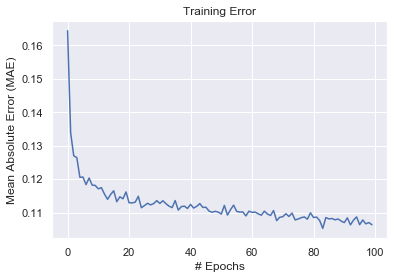

In [26]:
plt.plot(eth_history.epoch, eth_history.history["loss"])
plt.title('Training Error')

if eth_model.loss == "mae":
    plt.ylabel("Mean Absolute Error (MAE)")
else:
    plt.ylabel("Model Loss")
plt.xlabel("# Epochs")
plt.show

We have now built an LSTM model to predict tomorrow's ETH closing price!! Let's see how well it performs...

We can examine its performance on the traning set. We will use the mean absolute error (MAE) on the training set after the 50th iteration. Instead of relative changes, we can view the model output as daily closing prices.

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1, figsize=(13,7))

ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2020) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2020) for j in [1,5,9]])

ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:], training_set['eth_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:],
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['eth_Close'].values[:-window_len])[0], 
         label='Predicted')

ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)

ax1.legend(loc=2, borderaxespad=0., prop={'size': 14})

ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_training_inputs))+1)-\
            (training_set['eth_Close'].values[window_len:])/(training_set['eth_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')

# figure inset code 

axins = zoomed_inset_axes(ax1, 2, loc = 9) # zoom-factor: 3.35, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2020) for j in [1,5,9]])

axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:],training_set['eth_Close'][window_len:], label='Actual')
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:],
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['eth_Close'].values[:-window_len])[0], 
         label='Predicted')

axins.set_xlim([datetime.date(2018, 1, 1), datetime.date(2018, 5, 1)])
axins.set_ylim([650,1000])
axins.set_xticklabels('')
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()

We shouldn't be too surprised by its apparent accuracy here. The model has access to the source of its error and adjust itself accordingly. In fact, its very possible to attain almost zero training errors. We could just cram hundreds of neurons and train for thousands of epochs and the model could definelty remember the inputs completely - a process known as overfitting, where youre essentially predicting noise. I tried to adjust for this by including *Dropout()* layer in the model funcion, although it shouldn't the risk for our relatively small model. We shuold be more interested in its performance on the test dataset, as this represent complelely new data for the model. 

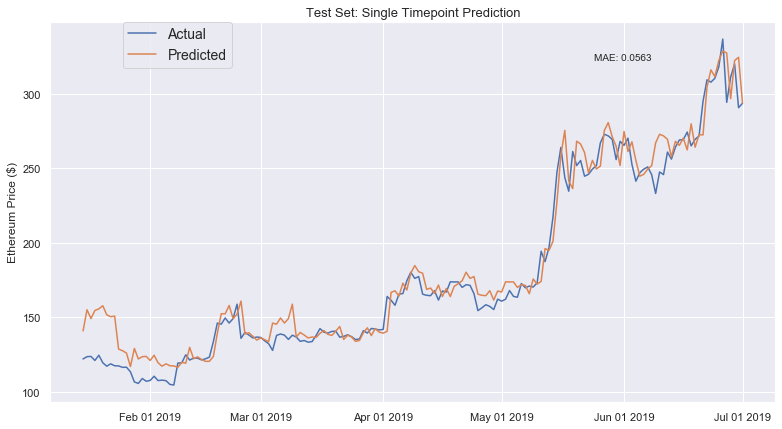

In [28]:
fig, ax1 = plt.subplots(1,1, figsize=(13,7))

ax1.set_xticks([datetime.date(2019,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2019,i+1,1).strftime('%b %d %Y')  for i in range(12)])

ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:],
         test_set['eth_Close'][window_len:], label='Actual')

ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:],
         ((np.transpose(eth_model.predict(LSTM_test_inputs))+1) * test_set['eth_Close'].values[:-window_len])[0], label='Predicted')

ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_test_inputs))+1)-\
            (test_set['eth_Close'].values[window_len:])/(test_set['eth_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction', xytext=(0.75, 0.9), textcoords='axes fraction')

ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

Caveats aside about the misleading nature of single point predictions, our LSTM model seems to have performed well on the unseen test set. 

In [33]:
# random seed for reproducibility
np.random.seed(42)
# initialise model architecture
btc_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# train model on data
# note: eth_history contains information on the training error per epoch
btc_history = bt_model.fit(LSTM_training_inputs, 
                            (training_set['btc_Close'][window_len:].values/training_set['btc_Close'][:-window_len].values)-1, 
                            epochs=10, batch_size=1, verbose=2, shuffle=True)
# #eth_model.save('eth_model%d.h5'%j)

Epoch 1/10
 - 7s - loss: 0.0599
Epoch 2/10
 - 7s - loss: 0.0604
Epoch 3/10
 - 7s - loss: 0.0601
Epoch 4/10
 - 7s - loss: 0.0597
Epoch 5/10
 - 7s - loss: 0.0598
Epoch 6/10
 - 7s - loss: 0.0602
Epoch 7/10
 - 7s - loss: 0.0604
Epoch 8/10
 - 7s - loss: 0.0602
Epoch 9/10
 - 7s - loss: 0.0599
Epoch 10/10
 - 7s - loss: 0.0593


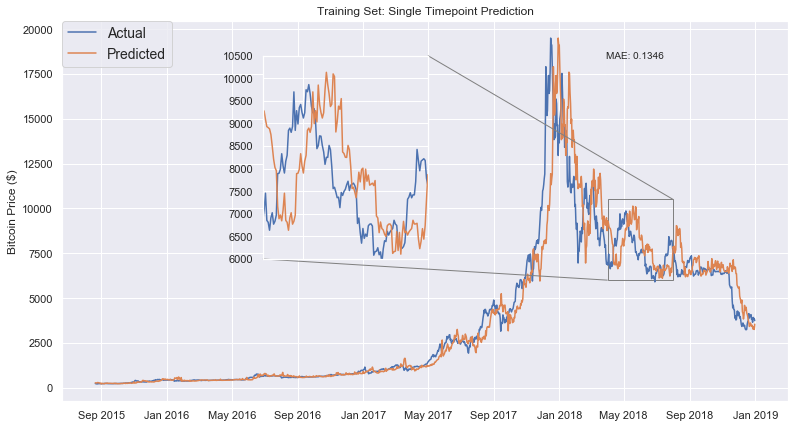

In [44]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1,figsize=(13,7))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2020) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2020) for j in [1,5,9]])

ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:],
         training_set['btc_Close'][window_len:], label='Actual')

ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:],
         ((np.transpose(btc_model.predict(LSTM_training_inputs))+1) * training_set['btc_Close'].values[:-window_len])[0], 
         label='Predicted')

ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(btc_model.predict(LSTM_training_inputs))+1)-\
            (training_set['btc_Close'].values[window_len:])/(training_set['btc_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')

ax1.legend( loc=2, borderaxespad=0., prop={'size': 14})

# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 2.52, loc=10, bbox_to_anchor=(400, 307)) # zoom-factor: 2.52, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2020) for j in [1,5,9]])
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:],
         training_set['btc_Close'][window_len:], label='Actual')
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:],
         ((np.transpose(btc_model.predict(LSTM_training_inputs))+1) * training_set['btc_Close'].values[:-window_len])[0], 
         label='Predicted')

axins.set_xlim([datetime.date(2018, 4, 1), datetime.date(2018, 8, 1)])
axins.set_ylim([6000,10500])
axins.set_xticklabels('')
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()

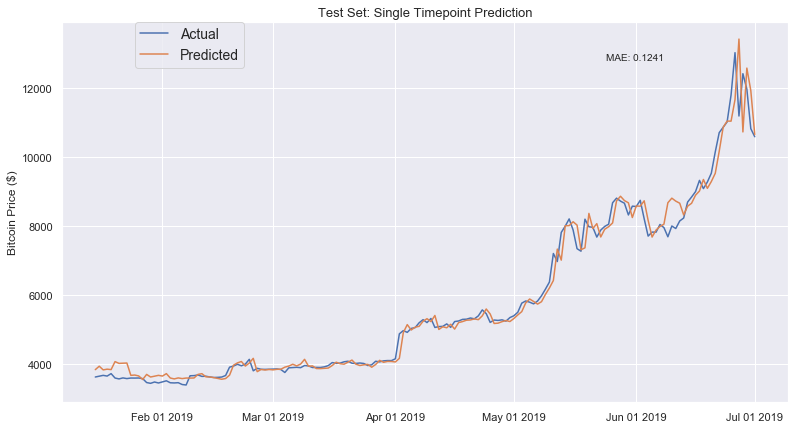

In [47]:
fig, ax1 = plt.subplots(1,1,figsize=(13,7))
ax1.set_xticks([datetime.date(2019,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2019,i+1,1).strftime('%b %d %Y')  for i in range(12)])

ax1.plot(model_data[model_data['Date']>= split_date]['Date'][14:],
         test_set['btc_Close'][window_len:], label='Actual')

ax1.plot(model_data[model_data['Date']>= split_date]['Date'][14:],
         ((np.transpose(bt_model.predict(LSTM_test_inputs))+1) * test_set['btc_Close'].values[:-window_len])[0], 
         label='Predicted')

ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(btc_model.predict(LSTM_test_inputs))+1)-\
            (test_set['btc_Close'].values[window_len:])/(test_set['btc_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')

ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

As I've stated earlier, single point predictions can be deceptive. Looking more closely, you'll notice that, again, the predicted values regularly mirror the previous values (e.g. October). Our fancy deep learning LSTM model has partially reproducted a autregressive (AR) model of some order p, where future values are simply the weighted sum of the previous p values. We can define an AR model in these mathematical terms:

$$\begin{align}
PredPrice_{t} &amp; = \phi_0 + \phi_1*Price_{t-1} + \ldots + \phi_p*Price_{t-p} + \epsilon_t, \ \epsilon_t \sim N(0, \sigma)\
\end{align}$$

The good news is that AR models are commonly employed in time series tasks (e.g. stock market prices), so the LSTM model appears to have landed on a sensible solution. The bad news is that it's a waste of the LSTM capabilities, we could have a built a much simpler AR model in much less time and probably achieved similar results (though the title of this post would have been much less clickbaity). More complex does not automatically equal more accurate).

We'll now build LSTM models to predict crypto prices for the next 5 days.

In [48]:
np.random.seed(42)

pred_range = 5

eth_model = build_model(LSTM_training_inputs, output_size = pred_range, neurons = 20)

LSTM_training_outputs = []

for i in range(window_len, len(training_set['eth_Close']) - pred_range):
    LSTM_training_outputs.append((training_set['eth_Close'][i:i+pred_range].values/
                                 training_set['eth_Close'].values[i-window_len]) -1)
    
LSTM_training_outputs = np.array(LSTM_training_outputs)

eth_history = eth_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs,
                           epochs = 100, batch_size = 1, verbose = 2, shuffle = True)

Epoch 1/100
 - 8s - loss: 0.2026
Epoch 2/100
 - 7s - loss: 0.1672
Epoch 3/100
 - 6s - loss: 0.1618
Epoch 4/100
 - 7s - loss: 0.1595
Epoch 5/100
 - 6s - loss: 0.1561
Epoch 6/100
 - 6s - loss: 0.1552
Epoch 7/100
 - 6s - loss: 0.1524
Epoch 8/100
 - 7s - loss: 0.1529
Epoch 9/100
 - 6s - loss: 0.1506
Epoch 10/100
 - 8s - loss: 0.1526
Epoch 11/100
 - 8s - loss: 0.1499
Epoch 12/100
 - 7s - loss: 0.1507
Epoch 13/100
 - 7s - loss: 0.1486
Epoch 14/100
 - 7s - loss: 0.1513
Epoch 15/100
 - 7s - loss: 0.1506
Epoch 16/100
 - 7s - loss: 0.1486
Epoch 17/100
 - 7s - loss: 0.1467
Epoch 18/100
 - 7s - loss: 0.1496
Epoch 19/100
 - 7s - loss: 0.1481
Epoch 20/100
 - 7s - loss: 0.1476
Epoch 21/100
 - 7s - loss: 0.1474
Epoch 22/100
 - 7s - loss: 0.1473
Epoch 23/100
 - 7s - loss: 0.1475
Epoch 24/100
 - 7s - loss: 0.1474
Epoch 25/100
 - 7s - loss: 0.1466
Epoch 26/100
 - 7s - loss: 0.1454
Epoch 27/100
 - 7s - loss: 0.1461
Epoch 28/100
 - 7s - loss: 0.1452
Epoch 29/100
 - 7s - loss: 0.1449
Epoch 30/100
 - 6s - lo

In [56]:
# random seed for reproducibility
np.random.seed(42)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 5
# initialise model architecture
btc_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['btc_Close'])-pred_range):
    LSTM_training_outputs.append((training_set['btc_Close'][i:i+pred_range].values/
                                  training_set['btc_Close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: eth_history contains information on the training error per epoch
btc_history = btc_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 7s - loss: 0.1218
Epoch 2/50
 - 6s - loss: 0.1008
Epoch 3/50
 - 6s - loss: 0.0895
Epoch 4/50
 - 6s - loss: 0.0848
Epoch 5/50
 - 6s - loss: 0.0830
Epoch 6/50
 - 6s - loss: 0.0812
Epoch 7/50
 - 6s - loss: 0.0808
Epoch 8/50
 - 6s - loss: 0.0804
Epoch 9/50
 - 7s - loss: 0.0801
Epoch 10/50
 - 7s - loss: 0.0799
Epoch 11/50
 - 7s - loss: 0.0798
Epoch 12/50
 - 7s - loss: 0.0787
Epoch 13/50
 - 7s - loss: 0.0794
Epoch 14/50
 - 7s - loss: 0.0788
Epoch 15/50
 - 7s - loss: 0.0777
Epoch 16/50
 - 7s - loss: 0.0784
Epoch 17/50
 - 7s - loss: 0.0779
Epoch 18/50
 - 7s - loss: 0.0773
Epoch 19/50
 - 7s - loss: 0.0773
Epoch 20/50
 - 7s - loss: 0.0774
Epoch 21/50
 - 7s - loss: 0.0771
Epoch 22/50
 - 7s - loss: 0.0774
Epoch 23/50
 - 7s - loss: 0.0772
Epoch 24/50
 - 7s - loss: 0.0768
Epoch 25/50
 - 7s - loss: 0.0761
Epoch 26/50
 - 7s - loss: 0.0766
Epoch 27/50
 - 7s - loss: 0.0762
Epoch 28/50
 - 7s - loss: 0.0760
Epoch 29/50
 - 7s - loss: 0.0757
Epoch 30/50
 - 7s - loss: 0.0760
Epoch 31/50
 - 7s -

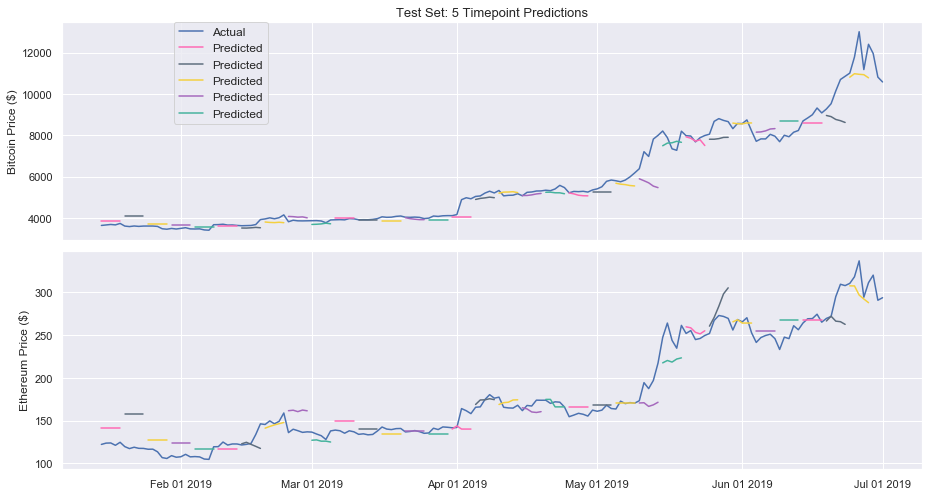

In [60]:
# little bit of reformatting the predictions to closing prices
eth_pred_prices = ((eth_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['eth_Close'].values[:-(window_len + pred_range)][::5].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))

btc_pred_prices = ((btc_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['btc_Close'].values[:-(window_len + pred_range)][::5].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))

pred_colors = ["#FF69B4", "#5D6D7E", "#F4D03F","#A569BD","#45B39D"]

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(13,7))
ax1.set_xticks([datetime.date(2019,i+1,1) for i in range(12)])
ax2.set_xticks([datetime.date(2019,i+1,1) for i in range(12)])
ax2.set_xticklabels([datetime.date(2019,i+1,1).strftime('%b %d %Y')  for i in range(12)])

ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:],
         test_set['btc_Close'][window_len:], label='Actual')
ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:],
         test_set['eth_Close'][window_len:], label='Actual')

for i, (eth_pred, btc_pred) in enumerate(zip(eth_pred_prices, btc_pred_prices)):
    # Only adding lines to the legend once
    if i<5:
        ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:][i*pred_range:i*pred_range+pred_range],
                 btc_pred, color=pred_colors[i%5], label="Predicted")
    else: 
        ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:][i*pred_range:i*pred_range+pred_range],
                 btc_pred, color=pred_colors[i%5])
    ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:][i*pred_range:i*pred_range+pred_range],
             eth_pred, color=pred_colors[i%5])

    ax1.set_title('Test Set: 5 Timepoint Predictions',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.set_xticklabels('')
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.13, 1), loc=2, borderaxespad=0., prop={'size': 12})
fig.tight_layout()
plt.show()

These predicionts are visibly less impressive than their single point counterparts. Nevertheless, the model returned somewhat nuanced behaviors; it simply didn't forecast prices to move uniformly in one direction. So this could be promising.

Moving back to the single point predictions, our deep machine artificial neural model looks okay, but so did that boring random walk model. Like the random walk model, LSTM models can be sensitive to the choice of random seed (the model weights are initially randomly assigned). So, if we want to compare the two models, we'll run each one multiple (say, 25) times to get an estimate for the model error. The error will be calculated as the absolute difference between the actual and predicted closing prices changes in the test set.

# Summary

We've collected some crypto data and fed it into a deep learning LSTM model. Unfortunately its predictions were not taht different from just spitting out the previous value. Moving on we need to decide on what we can do to the model so that it can learn more sophisticated behaviors...

* **Change Loss Function**: MAE doesn't encourage risk taking. More bespoke training focused loss functions could also move the model towards less conservative behaviours. 

* **Penalize conservative AR-type models**: This would incentivise the deep learning algorithm to explore more risky/interesting models...

* **Get more/or better data**: If past prices alone are sufficient to decently forecast future prices, we need to include other features that provide comparable predictive power. That way, the LSTM model wouldn't be so reliant on past prices, potentially unlocking more complex behaviours. 

It is also completely possible that there is not detectable pattern to changes in crypto prices; that no model can seperate singal from the noise ( similar to the merits of using Deep Learning to predict Earthquakes). This may suggest that deep learning simply isn't needed here and autoregressive models are still more effective.